The data set were downloed from [here](https://cycling.data.tfl.gov.uk/), the main goal for this project is to take the UK bike rental and try to predict the demand for certain hour for the month of January and half of February, the other half will be used for testing. 

Since the data comes separately, here i had to merge everything in a single dataset

In [1]:
import pandas as pd
import numpy as np
import os
from scipy import stats
import matplotlib.pylab as plt

In [2]:
aux=0
for i in os.listdir("./Data"):
    if i.endswith(".csv"):
        
        df=pd.read_csv("Data/"+i)
        df["End Date"]=pd.to_datetime(df["End Date"],format="%d/%m/%Y %H:%M")
        df["Start Date"]=pd.to_datetime(df["Start Date"],format="%d/%m/%Y %H:%M")
        if aux==0:
            final=df.copy()
        else:
            final=pd.concat([final,df],ignore_index=True)
        aux+=1
        print(df.columns,len(df.columns))
        

Index(['Rental Id', 'Duration', 'Bike Id', 'End Date', 'EndStation Id',
       'EndStation Name', 'Start Date', 'StartStation Id',
       'StartStation Name'],
      dtype='object') 9
Index(['Rental Id', 'Duration', 'Bike Id', 'End Date', 'EndStation Id',
       'EndStation Name', 'Start Date', 'StartStation Id',
       'StartStation Name'],
      dtype='object') 9
Index(['Rental Id', 'Duration', 'Bike Id', 'End Date', 'EndStation Id',
       'EndStation Name', 'Start Date', 'StartStation Id',
       'StartStation Name'],
      dtype='object') 9
Index(['Rental Id', 'Duration', 'Bike Id', 'End Date', 'EndStation Id',
       'EndStation Name', 'Start Date', 'StartStation Id',
       'StartStation Name'],
      dtype='object') 9
Index(['Rental Id', 'Duration', 'Bike Id', 'End Date', 'EndStation Id',
       'EndStation Name', 'Start Date', 'StartStation Id',
       'StartStation Name'],
      dtype='object') 9
Index(['Rental Id', 'Duration', 'Bike Id', 'End Date', 'EndStation Id',
       '

In [3]:
final=final.drop(["End Date","EndStation Id","EndStation Name","StartStation Id"],axis=1).sort_values(by="Start Date")

# Exploring the distributions of duration
the amin goal of this part is to study the behaviour of the distribution in the duration of the trips

In [4]:
grouped = final.set_index("Start Date").iloc[:60000].groupby(pd.Grouper(freq="1H"))["Duration"]



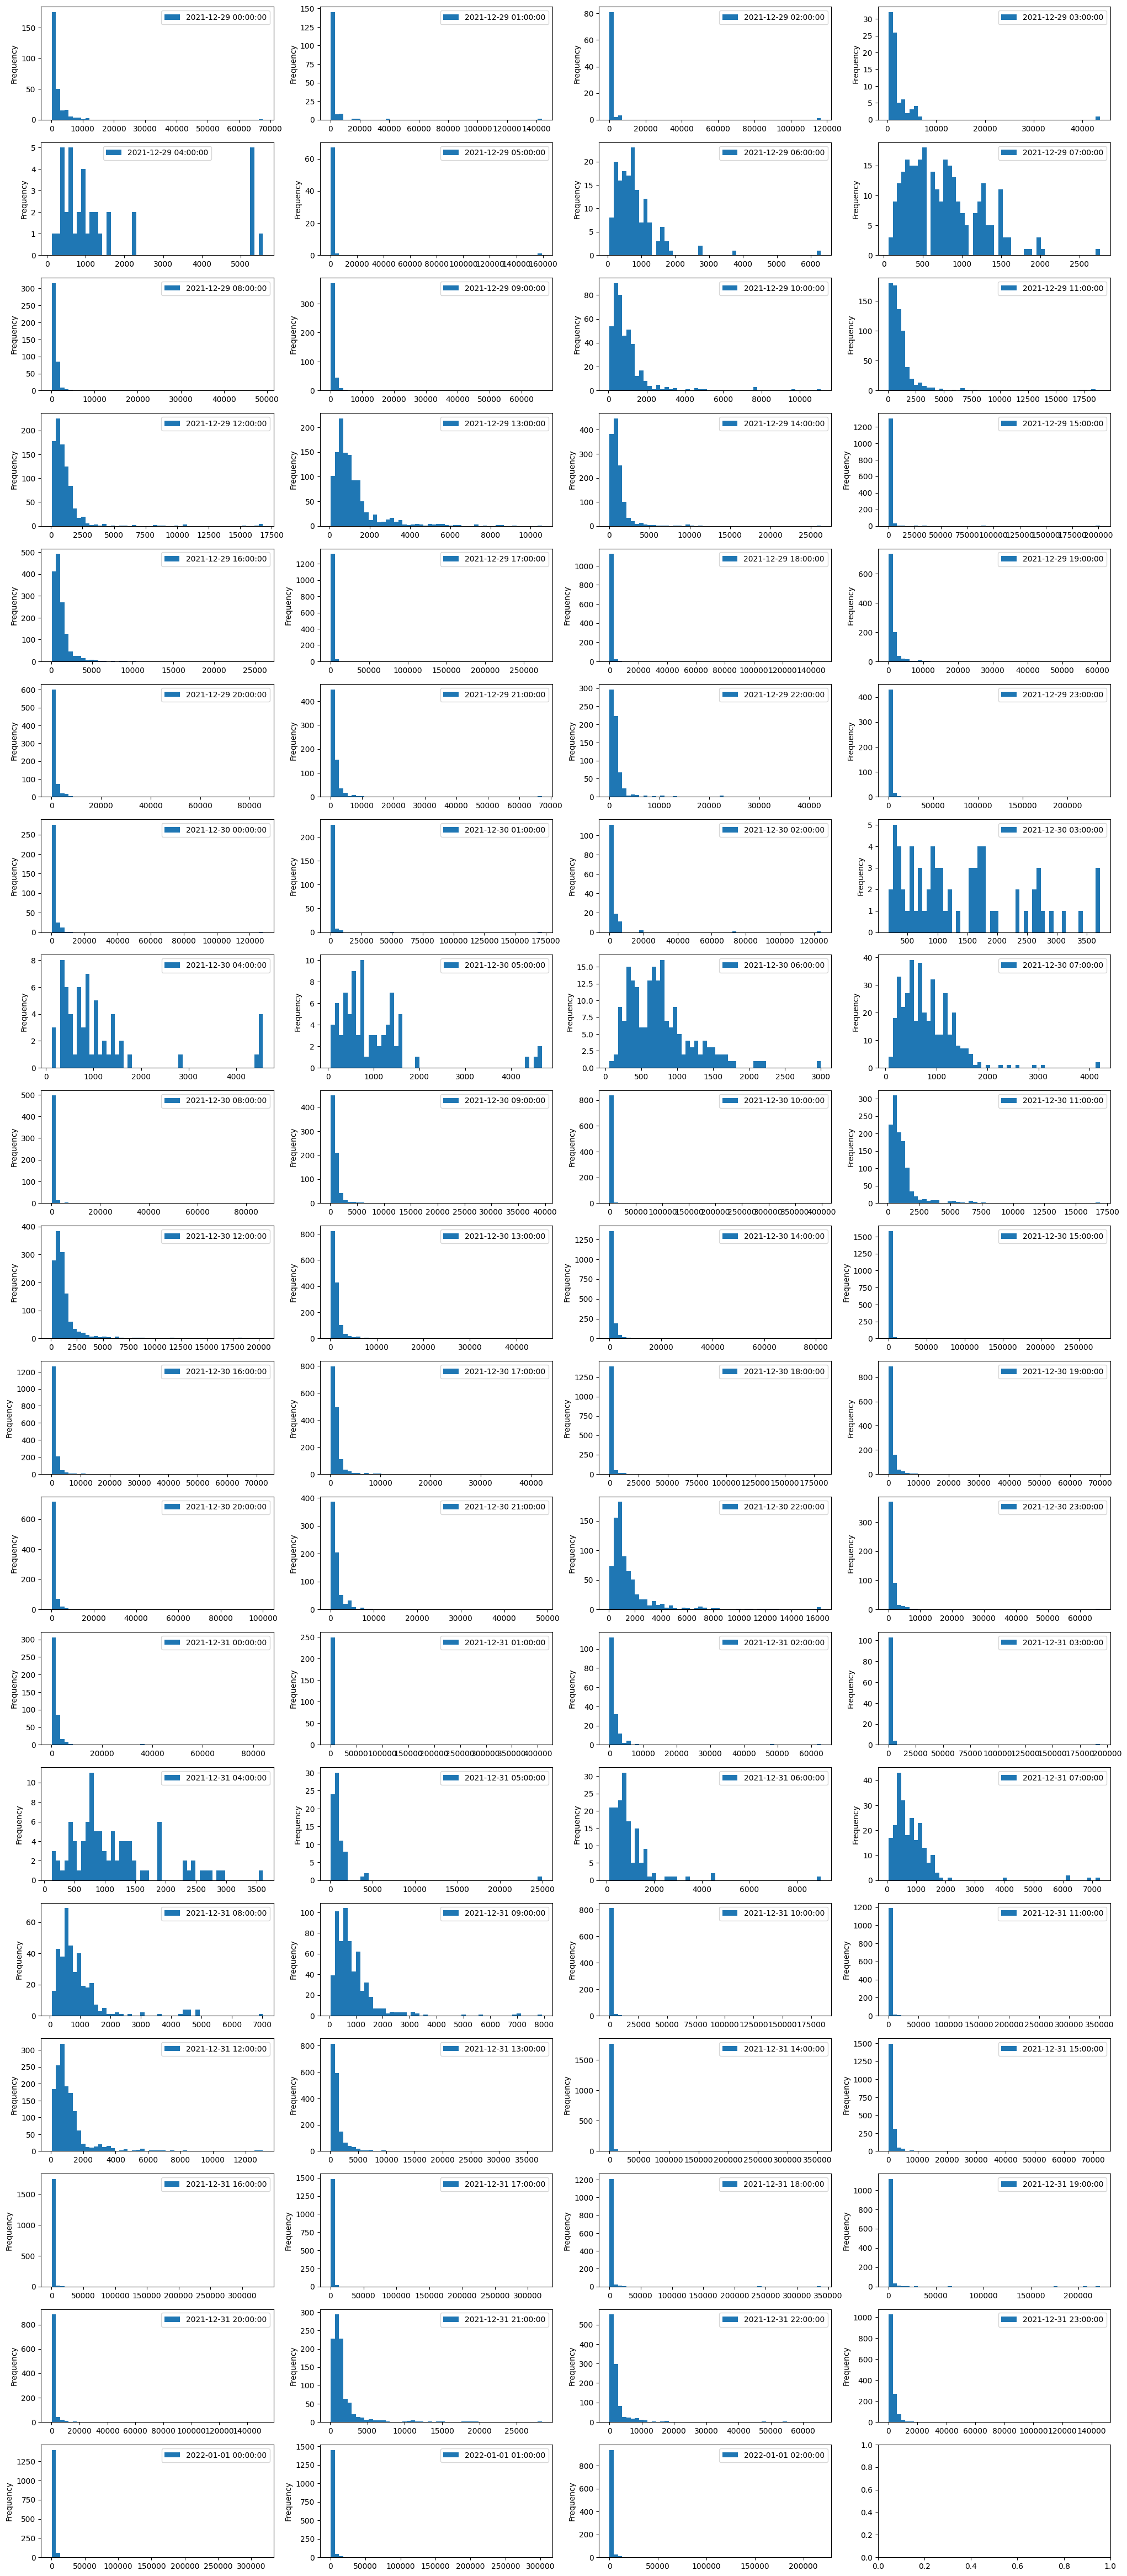

In [5]:
ncols=4
nrows = int(np.ceil(grouped.ngroups/ncols))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(25,60))

for (key, ax) in zip(grouped.groups.keys(), axes.flatten()):
    grouped.get_group(key).plot(ax=ax,kind="hist",bins=50,label=key)
    ax.legend()
plt.show()

Since the distribution is quite skewed we are going to take some quantiles and some statistics to keep in mind and use them later on

In [6]:
def q75(x):
    return x.quantile(0.75)

# 90th Percentile
def q90(x):
    return x.quantile(0.9)

new_data=final.set_index("Start Date").resample("1H")["Duration"].agg(["mean","count","std","max","min",np.median,q75,q90])
new_data.head(10)

,mean,count,std,max,min,median,q75,q90
Start Date,,,,,,,,
2021-12-29 00:00:00,2007.011070,271,4438.863334,67680,60,1080.0,1980.0,4320.0
2021-12-29 01:00:00,2611.097561,164,11661.543164,143700,60,900.0,1560.0,3204.0
2021-12-29 02:00:00,2526.896552,87,12413.009240,116640,180,960.0,1530.0,2100.0
2021-12-29 03:00:00,2352.000000,80,4906.806020,43560,240,1380.0,2340.0,5400.0
2021-12-29 04:00:00,1613.513514,37,1729.785176,5580,120,900.0,1560.0,5280.0
2021-12-29 05:00:00,3144.347826,69,19079.221180,159240,60,720.0,1140.0,1380.0
2021-12-29 06:00:00,806.415094,159,676.993805,6300,60,720.0,960.0,1452.0
2021-12-29 07:00:00,747.741935,279,451.090116,2760,60,660.0,1020.0,1380.0
2021-12-29 08:00:00,966.762590,417,2552.899431,49020,60,660.0,1020.0,1440.0


More over we are going to check if the day is a work day and is that thay is a holiday

In [7]:
import holidays
uk_holidays = holidays.UnitedKingdom()
def check_workday(x):
    if x.weekday() <5:
        if str(x) in uk_holidays:
            answer=False
        answer=True
    else:
        answer=False
    return answer
def check_holiday(x):
    if str(x) in uk_holidays:
        return True
    return False

In [8]:
holidays_check=new_data.reset_index()["Start Date"].apply([check_workday,check_holiday])
holidays_check.columns=["WorkDay","Holiday"]
bikes_data=pd.concat([new_data.reset_index(),holidays_check],axis=1)

In [9]:
bikes_data=bikes_data[(bikes_data["Start Date"]>="2022-01-01 00:00:00") & (bikes_data["Start Date"]<"2022-03-01 00:00:00")].reset_index(drop=True)
bikes_data.to_csv("final.csv",index=False)

In [10]:
bikes_data

,Start Date,mean,count,std,max,min,median,q75,q90,WorkDay,Holiday
0,2022-01-01 00:00:00,2748.244898,1470,13203.672449,317460,60,1380.0,2280.0,4086.0,False,True
1,2022-01-01 01:00:00,2774.138381,1532,11855.269068,302160,60,1320.0,2220.0,3780.0,False,True
2,2022-01-01 02:00:00,2116.549815,1084,8154.374492,218040,60,1140.0,1800.0,3060.0,False,True
3,2022-01-01 03:00:00,2755.000000,696,12882.682470,221400,60,960.0,1575.0,3180.0,False,True
4,2022-01-01 04:00:00,2501.744966,447,14558.730159,298020,60,1080.0,1800.0,3300.0,False,True
...,...,...,...,...,...,...,...,...,...,...,...
1411,2022-02-28 19:00:00,792.233463,1285,779.411317,15120,60,660.0,1020.0,1380.0,True,False
1412,2022-02-28 20:00:00,823.869132,703,1777.751660,41820,60,600.0,900.0,1320.0,True,False
1413,2022-02-28 21:00:00,761.183432,507,1423.300241,31260,60,600.0,900.0,1320.0,True,False
1414,2022-02-28 22:00:00,774.488189,381,764.554265,10500,60,600.0,960.0,1440.0,True,False


In [11]:
tmp=bikes_data.set_index("Start Date").groupby(["WorkDay",pd.Grouper(freq="1H")])["count"].sum().to_frame().reset_index()

<AxesSubplot:ylabel='Frequency'>

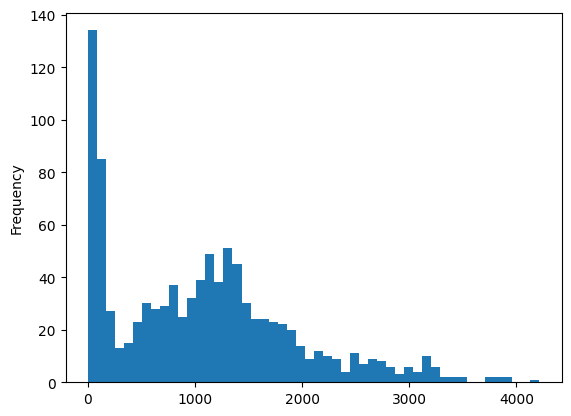

In [12]:
tmp[tmp["WorkDay"]]["count"].plot.hist(bins=50)

<AxesSubplot:ylabel='Frequency'>

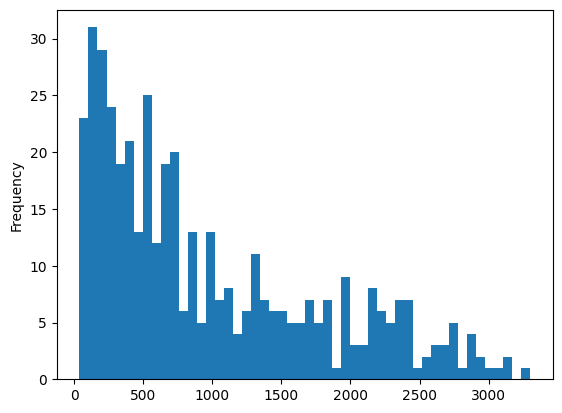

In [13]:
tmp[~tmp["WorkDay"]]["count"].plot.hist(bins=50)

In [14]:
bikes_data["hour"]=bikes_data["Start Date"].dt.hour

<AxesSubplot:xlabel='hour'>

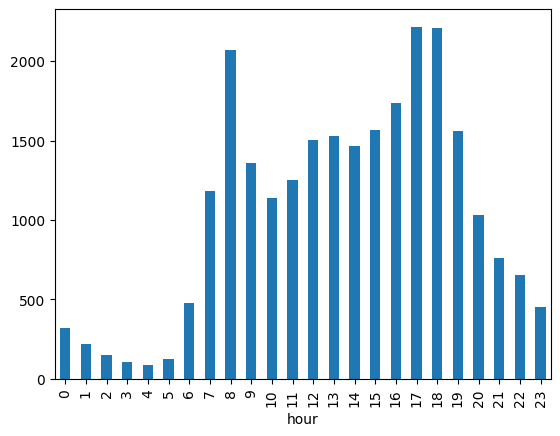

In [15]:
bikes_data.groupby("hour")["count"].mean().plot.bar()

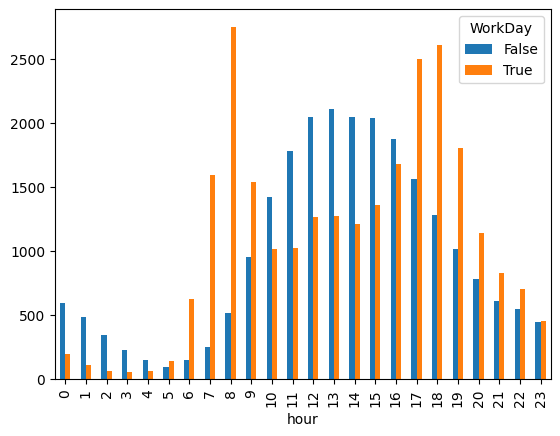

In [16]:
tmp=bikes_data.groupby(["hour","WorkDay"])["count"].mean().unstack().plot(kind='bar')

# Taking into account the weather
In order to provide a bit more insights to our models we are going to also include the historic data of the weather in london by hour This particular data was taken from the free API the offers [visual crossing](https://www.visualcrossing.com/)

In [17]:
aux=0
for i in os.listdir():
    if i.startswith("london"):
        if aux==0:
            weather=pd.read_csv(i)
        else:
            weather=pd.concat([weather,pd.read_csv(i)],ignore_index=True)
        aux+=1

In [18]:

weather["datetime"]=pd.to_datetime(weather["datetime"],format="%Y-%m-%dT%H:%M:%S")

In [19]:
weather.columns

Index(['name', 'datetime', 'temp', 'feelslike', 'dew', 'humidity', 'precip',
       'precipprob', 'preciptype', 'snow', 'snowdepth', 'windgust',
       'windspeed', 'winddir', 'sealevelpressure', 'cloudcover', 'visibility',
       'solarradiation', 'solarenergy', 'uvindex', 'severerisk', 'conditions',
       'icon', 'stations'],
      dtype='object')

In [20]:
tmp=weather.drop(['stations',"name",'severerisk',"uvindex",'sealevelpressure','precipprob','preciptype','precip','windspeed','windgust', 'winddir','solarradiation', 'solarenergy',"snow","snowdepth"],axis=1)

Since we are not quite interested in the duration itself we are going to only use the data of the hour and the weather conditions, so this is not going to be treated ad a time series problem but instead we are trying to see if there is a pattern given the hour and the weather

In [30]:
final_data=pd.concat([bikes_data.set_index("Start Date"),tmp.set_index("datetime")],join="inner",axis=1)
final_data=final_data.reset_index()
final_data.rename(columns={"index":"Date"},inplace=True)
numerical=["Date","hour","temp","feelslike","dew","humidity","cloudcover","visibility","count"]
categorical=["WorkDay","Holiday","conditions","icon"]
final_data=final_data[numerical+categorical]
final_data.to_csv("final.csv",index=False)

In [27]:
from pandas_profiling import ProfileReport

In [28]:
profile = ProfileReport(
    final_data, title="Bike weather report", html={"style": {"full_width": True}}, sort=None
)

In [29]:
profile.to_file("report_Bikes.html")

Export report to file: 100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.90it/s]
